<a href="https://colab.research.google.com/github/bkaplowitz/Tax-Smoothing/blob/master/tax_smoothing_examples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Examples for Brandon

Here are some examples of Markov chains to put into the code you revised yesterday to accommodate $N > 2$

In the following examples the parameteres $\lambda, \gamma, \phi$ are all fractions living in $[0,1]$

You can set them all to $.5$ initially, but we can have fun experimenting with other values

Please make the output "verbose" at this stage so that you print out lots of the objects that the code computes,
e.g., debt levels, tax  collections, and so on.

## Setup

In [1]:
!pip install --upgrade quantecon

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.5)


In [0]:
import numpy as np
import quantecon as qe
import scipy.linalg as la


def isprobabilitymatrix(P: np.ndarray):
  try:
    assert(np.all(P>=0)==True)
  except AssertionError:
    print("Matrix has negative entries")
  k,l=P.shape
  try:
    assert(k==l)
  except AssertionError:
    print("Matrix is non-symmetric")
  try:
    assert(np.all(np.sum(P,axis=1,keepdims=True)==np.ones((1,k))))
  except AssertionError:
    print("Matrix rows do not sum to 1")
  try:
    assert(isinstance(P,np.ndarray))
  except AssertionError:
    print("Not array-like")

class ConsumptionProblem:
    """
    The data for a consumption problem, including some default values.
    """

    def __init__(self,
                 β=.96,
                 y=[2, 1.5,3],
                 b0=3,
                 P=np.asarray([[.8, .1, .1],
                               [.2, .6,.2],
                               [.3,.4,.3]])):
        """

        Parameters
        ----------

        β : discount factor
        P : n x n transition matrix
        y : list containing the n income levels
        b0 : debt in period 0 (= state_1 debt level)

        """
        try:
          assert((β>=0) & (β<=1))
        except AssertionError:
          print('β must be in (0,1)')
        try:
          assert(np.all(np.isreal(y))==True)
        except AssertionError:
          print('y must be a real number')
        try:
           assert(np.all(np.isreal(b0))==True)
        except AssertionError:
          print('b0 must be a real number')
        isprobabilitymatrix(P) 
        self.β = β
        self.y = y
        self.b0 = b0
        self.P = P
        self.n = np.size(y)

  
      
def consumption_complete(cp, N_simul=150, initval=0, seed=2019):
    """
    Computes endogenous values for the complete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem
    N_simul : int
    initval : state to start from, with 0 corresponding to state 1

    Returns
    -------

        c_bar : constant consumption
        b: vector of debts in each state

    associated with the price system 

        Q = β * P

    """
    
    
    β, P, y, b0, n = cp.β, cp.P, cp.y, cp.b0, cp.n   # Unpack
    #b[0] = b0                               # b(s1) is known to be equal to b0
    Q = β * P                               # assumed price system
    
    np.random.seed(2019)
    mc=qe.MarkovChain(P) # simulates markov chain using QE package.
    
    
    # Using equation (7-9) calculate b2, where we will stack the time 0 equation
    # on top of our existing n equations. Our new y variable will represent all 
    # net income, with the top being y(s_1)-b_0
    # our new b variable will be called X and will capture all choice variables
    # with the first entry being c_bar.
    # X= [c_bar; b]
    # G  [1 0 0 0 0 0...; 
    #     1 1 0........;
    #     1 0 1 ...]
    #E.g [ 1, 0 ]
    #    [ 1, I ]
    #G@X = [y(s_1)-b_0;Y_VEC]+Q_new (left entry is all 0's now)@np.asarray(X) 
    #c_bar = y(s_1)+Q[0,:]@np.asarray(b)-b_0
    # (G-Q_new)@X=[y(s_1)-b_0;Y_VEC]
    # X= (G-Q_new)^{-1}@[y(s_1)-b_0;Y_VEC]
    G = np.block([ #represents the fact that we don't observe b and c_bar seperately, only b(s_j)+c_bar on LHS
                  [1,np.zeros((1,n))],
                  [np.ones((n,1)), np.eye(n)]
                  ])
    y_aug= np.concatenate((np.atleast_2d(y[0]-b0),np.atleast_2d(y).T)) #construct our new y, state variables
    Q_aug = np.block([ #construct our new Q matrix that involves both the time 0 prices (same as state 1) and prices for all other states
                  [0,Q[0,:]],
                  [np.zeros((n,1)),Q]                
    ])
    X = np.linalg.inv((G-Q_aug)) @ y_aug # solve for X using the linear algebra calculations above.
    c_bar=X[0,:] #unroll solved for x
    b = X[1:n+1,:]
    c_bar = np.ndarray.item(c_bar)
    b= b.flatten()
    # compute simulated path
    s_path = mc.simulate(N_simul, init=0)
    b_path=np.append(b0,b[s_path])
    c_path = np.array(np.repeat(c_bar, N_simul))
    y=np.asarray(y)
    y_path = y[s_path]
    # return values of c_bar and b for each state and the path of each
    return c_bar, b, c_path, b_path[:-1],y[s_path], s_path


def consumption_incomplete(cp, N_simul=150, initval=0, seed=2019):
    """
    Computes endogenous values for the incomplete market case.

    Parameters
    ----------

    cp : instance of ConsumptionProblem
    N_simul : int
    initval : state to start from with 0 corresponding to state 1.

    """

    β, P, y, b0,n  = cp.β, cp.P, cp.y, cp.b0, cp.n  # Unpack
    np.random.seed(seed)
    # For the simulation define a quantecon MC class
    mc = qe.MarkovChain(P)

    # Useful variables
    y = np.asarray(y).reshape(n, 1)
    v = np.linalg.inv(np.eye(n) - β * P) @ y

    # Simulate state path
    s_path = mc.simulate(N_simul, initval)

    # Store consumption and debt path
    b_path, c_path = np.ones(N_simul + 1), np.ones(N_simul)
    b_path[0] = b0

    # Optimal decisions from (12) and (13)
    db = ((1 - β) * v - y) / β

    for i, s in enumerate(s_path):
        c_path[i] = (1 - β) * (v - b_path[i] * np.ones((np.size(y), 1)))[s, 0]
        b_path[i + 1] = b_path[i] + db[s, 0]

    return c_path, b_path[:-1], y[s_path], s_path

## Parameters

In [0]:
γ = .5
λ = .5
ϕ = .5
G_L=.5
G_M=.8
G_H =1.2

### Example 1

This example is designed to emulate the Civil War and WWI

$$ P = \begin{bmatrix} 1 - \lambda & \lambda & 0 \cr
                       0 & 1 - \phi & \phi \cr
                       0 & 0 & 1 \end{bmatrix} $$

where the government expenditure vector  $g = \begin{bmatrix} g_L & g_H & g_M \end{bmatrix}$
where $ g_L < g_M < g_H$ .  Please assume $b_0 = 0$ and assume that the initial Markov state is
state $1$ so that the system starts off in peace.

Please apply the code for both the complete and the incomplete markets tax-smoothing models and plot
outcomes as they are in one of the graphs in the present notebook from quantecon or from your notebook from
yesterday

In [0]:
g= [G_L,G_M,G_H]

P_1 = np.array([
    [1-λ, λ, 0 ],
    [0, 1-ϕ, ϕ],
    [0, 0, 1  ]])

b0_1= 0
initstate_1= 0
N_simul=150
seed=2020

cp_1 = ConsumptionProblem(
    P=P_1,y=g,b0=b0_1)

c_bar_complete, b_complete, c_path_complete, b_path_complete, g_path_complete, s_path_complete = consumption_complete(cp_1,
                                                                                                                      initval=initstate_1,
                                                                                                                      N_simul=N_simul, seed=seed)

c_path_incomplete, b_path_incomplete, g_path_incomplete, s_path_incomplete = consumption_incomplete(cp_1, 
                                                                                                    initval=initstate_1, 
                                                                                                    N_simul=N_simul, seed=seed)

### Complete and Incomplete markets

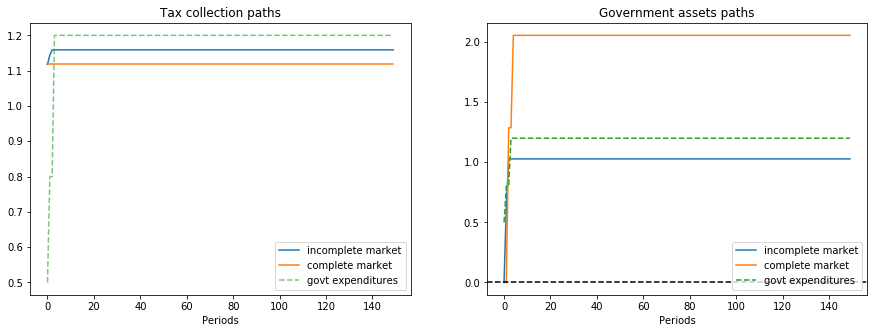

In [71]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

ax[0].set_title('Tax collection paths')
ax[0].plot(np.arange(N_simul), c_path_incomplete, label='incomplete market')
ax[0].plot(np.arange(N_simul), c_path_complete, label='complete market')
ax[0].plot(np.arange(N_simul), g_path_complete, label='govt expenditures', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('Periods')

ax[1].set_title('Government assets paths')
ax[1].plot(np.arange(N_simul), b_path_incomplete, label='incomplete market')
ax[1].plot(np.arange(N_simul), b_path_complete, label='complete market')
ax[1].plot(np.arange(N_simul), g_path_complete, label='govt expenditures', ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('Periods')

plt.show()

### First 20 periods only

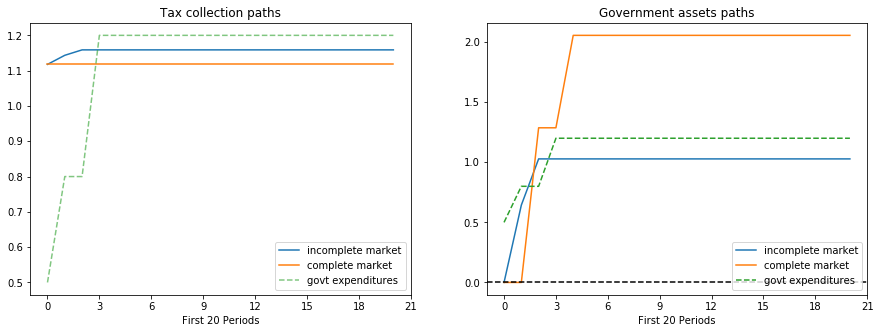

In [78]:
from matplotlib.ticker import MaxNLocator

N=21


fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Tax collection paths')
ax[0].plot(np.arange(N), c_path_incomplete[0:N], label='incomplete market')
ax[0].plot(np.arange(N), c_path_complete[0:N], label='complete market')
ax[0].plot(np.arange(N), g_path_complete[0:N], label='govt expenditures', alpha=.6, ls='--')
ax[0].legend()
ax[0].set_xlabel('First 20 Periods')
ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))


ax[1].set_title('Government assets paths')
ax[1].plot(np.arange(N), b_path_incomplete[0:N], label='incomplete market')
ax[1].plot(np.arange(N), b_path_complete[0:N], label='complete market')
ax[1].plot(np.arange(N), g_path_complete[0:N], label='govt expenditures', ls='--')
ax[1].legend()
ax[1].axhline(0, color='k', ls='--')
ax[1].set_xlabel('First 20 Periods',)
ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))

plt.show()

### Example 2

This example captures a permanent peace.  

Here set

$$ P = \begin{bmatrix}   1 & 0 & 0 \cr
                         0 & 1-\gamma & \gamma \cr
                         \phi & 0 & 1-\phi \end{bmatrix} $$
                       
where the government expenditure vector  $g = \begin{bmatrix} g_L & g_L & g_H \end{bmatrix}$
where $ g_L < g_H$ .  Please assume $b_0 = 0$ and assume that the initial Markov state is state $2$ so that 
the system starts off in a temporary peace.  


Please apply the code for both the complete and the incomplete markets tax-smoothing models and plot
outcomes as they are in one of the graphs in the present notebook from quantecon or from your notebook from
yesterday




state $1$ so that the system starts off in peace.          

In [0]:
g= [G_L,G_L,G_H]

P_1 = np.array([
    [1, 0, 0 ],
    [0, 1-γ, γ],
    [ϕ, 0, 1  ]])

b0_1= 0
initstate_1= 0
N_simul=150
seed=2020